In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights
from copy import deepcopy
import mplcyberpunk
plt.style.use("cyberpunk")
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
if torch.cuda.is_available():
    print("CUDA доступна!")
    device = torch.device("cuda")
else:
    print("CUDA недоступна. Вычисления будут выполняться на CPU.")
    device = torch.device("cpu")

CUDA доступна!


In [3]:
resize = T.Resize((224, 224))

In [4]:
img = resize(io.read_image('../SCMB/data/test/benign/105.jpg')/255)
img2 = resize(io.read_image('../SCMB/data/test/malignant/200.jpg')/255)

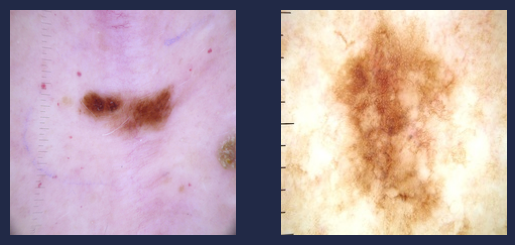

In [5]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(torch.permute(img, (1, 2, 0)))
ax[1].imshow(torch.permute(img2, (1, 2, 0)))
[(i.set_xticks([]), i.set_yticks([])) for i in ax];

In [6]:
trnsfrms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

In [7]:
train_dataset = torchvision.datasets.ImageFolder('../SCMB/data/train', transform=trnsfrms)
valid_dataset = torchvision.datasets.ImageFolder('../SCMB/data/test', transform=trnsfrms)

In [8]:
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
test_b_s, test_b_l = next(iter(train_loader))

In [10]:
test_b_s.shape

torch.Size([256, 3, 224, 224])

In [11]:
weights_SCMB = ResNet50_Weights.DEFAULT
model_SCMB = resnet50(weights=weights_SCMB)

In [12]:
model_SCMB.fc = nn.Linear(2048, 1)

In [13]:
for param in model_SCMB.parameters():
    param.requires_grad = False

In [14]:
for param in model_SCMB.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [15]:
model_SCMB.fc.weight.requires_grad = True
model_SCMB.fc.bias.requires_grad = True

In [16]:
for param in model_SCMB.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [17]:
model_SCMB.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
optimizer_SCMB = torch.optim.Adam(model_SCMB.parameters())
criterion = torch.nn.BCEWithLogitsLoss()

In [19]:
def fit(
        model: nn.Module, 
        n_epochs: int, 
        optimizer: torch.optim.Optimizer,
        train_loader: DataLoader,
        valid_loader: DataLoader,
        criterion = criterion,
        history = None
        ) -> tuple[list, ...]:

    history = history or {
        'train_loss': [],
        'valid_loss': [],
        'train_metric': [],
        'valid_metric': [], 
        'f1_score_train' : [],
        'f1_score_valid' : [],
        'y_pred' : [],
        'labels' : [],
    }

    for epoch in range(n_epochs):
        model.train()
        batch_accs = []
        batch_losses = []
        batch_f1_score = []
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            y_pred = model(images).squeeze(-1)
            loss = criterion(y_pred, labels.float())

            batch_losses.append(loss.item())
            accuracy = (y_pred.sigmoid().round() == labels).cpu().numpy().mean()
            batch_accs.append(accuracy)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_f1_score.append(f1_score(labels.cpu().numpy(), y_pred.cpu().sigmoid().round().detach().numpy()))
        history['train_loss'].append(np.mean(batch_losses))
        history['train_metric'].append(np.mean(batch_accs))
        history['f1_score_train'].append(np.mean(batch_f1_score))

        model.eval()
        batch_accs = []
        batch_losses = []
        batch_f1_score = []

        for images, labels in valid_loader:
            with torch.no_grad():
                y_pred = model(images.to(device)).squeeze(-1)
            loss = criterion(y_pred, labels.float().to(device))

            batch_losses.append(loss.item())
            batch_accs.append((y_pred.cpu().sigmoid().round() == labels.cpu()).numpy().mean())
            batch_f1_score.append(f1_score(labels.cpu().numpy(), y_pred.cpu().sigmoid().round().detach().numpy()))
            history['y_pred'].extend(y_pred.cpu().sigmoid().round().numpy())
            history['labels'].extend(labels.cpu().numpy())
        history['valid_loss'].append(np.mean(batch_losses))
        history['valid_metric'].append(np.mean(batch_accs))
        history['f1_score_valid'].append(np.mean(batch_f1_score))


        print(
            f'Epoch {epoch} train: accuracy {history["train_metric"][-1]:.4f}, loss {history["train_loss"][-1]:.4f}\n'
            f'Epoch {epoch} valid: accuracy {history["valid_metric"][-1]:.4f}, loss {history["valid_loss"][-1]:.4f}'
        )
        print(f'{"-"*35}')
        print()

    return history

In [20]:
model_SCMB_result = fit(model=model_SCMB, n_epochs=20, optimizer=optimizer_SCMB, train_loader=train_loader, valid_loader=valid_loader)

Epoch 0 train: accuracy 0.6138, loss 0.6291
Epoch 0 valid: accuracy 0.6112, loss 0.6421
-----------------------------------

Epoch 1 train: accuracy 0.8244, loss 0.5164
Epoch 1 valid: accuracy 0.7376, loss 0.5705
-----------------------------------

Epoch 2 train: accuracy 0.8376, loss 0.4518
Epoch 2 valid: accuracy 0.7873, loss 0.4919
-----------------------------------

Epoch 3 train: accuracy 0.8511, loss 0.4083
Epoch 3 valid: accuracy 0.8466, loss 0.4147
-----------------------------------

Epoch 4 train: accuracy 0.8531, loss 0.3822
Epoch 4 valid: accuracy 0.8466, loss 0.3843
-----------------------------------

Epoch 5 train: accuracy 0.8559, loss 0.3630
Epoch 5 valid: accuracy 0.8504, loss 0.3642
-----------------------------------

Epoch 6 train: accuracy 0.8605, loss 0.3525
Epoch 6 valid: accuracy 0.8594, loss 0.3550
-----------------------------------

Epoch 7 train: accuracy 0.8609, loss 0.3398
Epoch 7 valid: accuracy 0.8599, loss 0.3507
-----------------------------------



In [21]:
res_SCMB = deepcopy(model_SCMB_result)

In [22]:
model_SCMB.to('cpu')
torch.cuda.empty_cache()

In [23]:
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    
    ax[0].plot(history['train_loss'], label='train loss')
    ax[0].plot(history['valid_loss'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_loss"])}')
    ax[0].grid(grid)
    ax[0].set_ylim((min(history['train_loss'] + history['valid_loss']) - .1, max(history['train_loss'] + history['valid_loss']) + .1))
    ax[0].legend()
    
    ax[1].plot(history['train_metric'], label='train acc')
    ax[1].plot(history['valid_metric'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_metric"])}')
    ax[1].grid(grid)
    ax[1].set_ylim((min(history['train_metric'] + history['valid_metric'])-.1, max(history['train_metric'] + history['valid_metric'])+.1))
    ax[1].legend()
    
    plt.show()

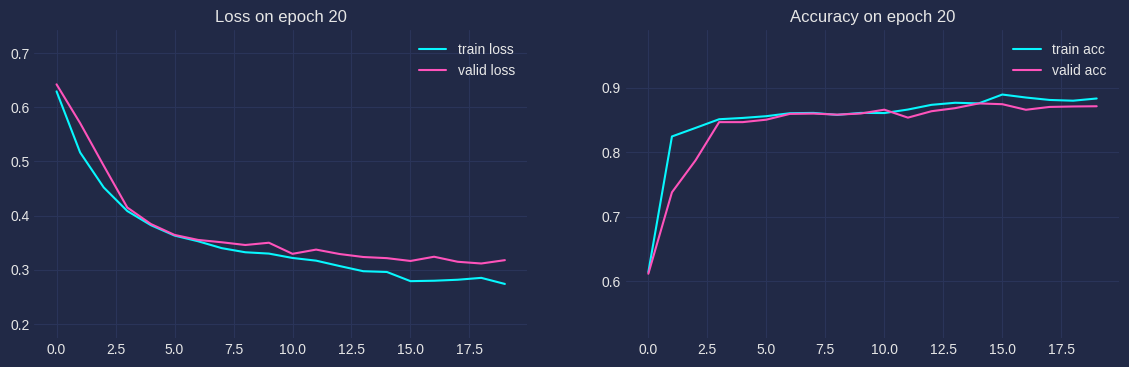

In [24]:
plot_history(res_SCMB)

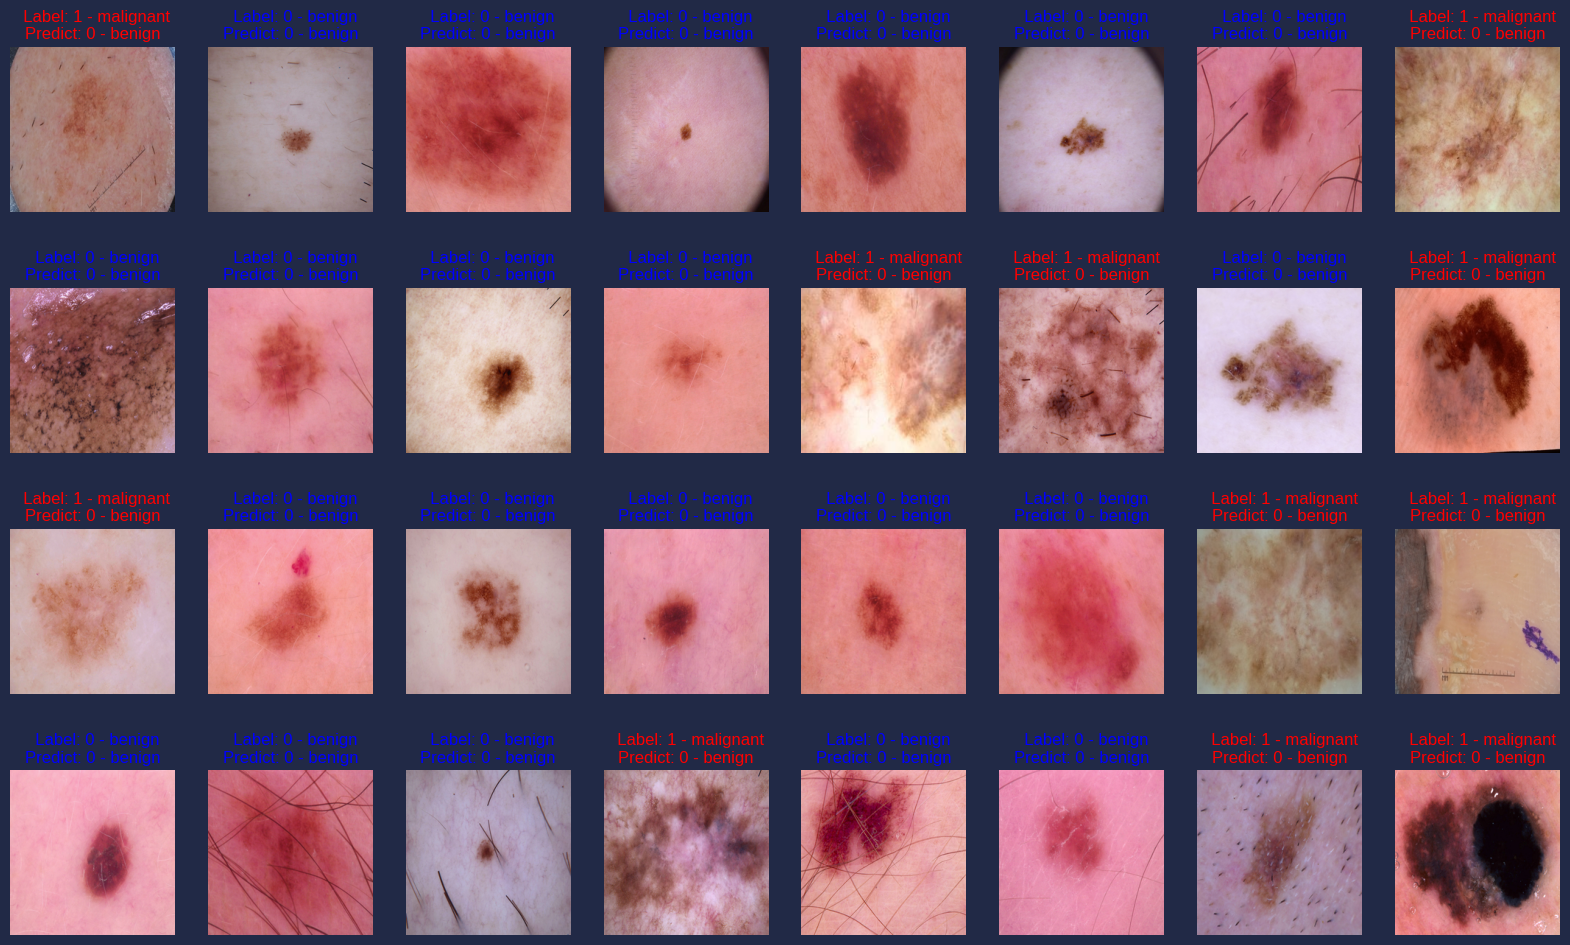

In [25]:
fig, ax = plt.subplots(4, 8, figsize=(20, 12))
ax = ax.flatten()
test_batch = next(iter(valid_loader))
test_samples, test_targets = test_batch
test_samples = test_samples.to(device)
model_SCMB.to(device)
for i, plot in enumerate(ax):
    label_index = test_targets[i].item()
    y_pred = torch.argmax(model_SCMB(test_samples[i].unsqueeze(0)))
    y_pred = y_pred.cpu().detach().numpy()
    color = 'r' if y_pred != label_index else 'b'
    plot.set_title(f'  Label: {label_index} - {train_loader.dataset.classes[label_index]}\n'
                   f'Predict: {y_pred} - {train_loader.dataset.classes[y_pred]}', color=color)
    if test_samples[i].shape[0] == 3:
        img = test_samples[i].permute(1, 2, 0)
    plot.imshow(img.cpu())
    plot.axis('off')

In [26]:
idx2class= {j: i for i, j in train_dataset.class_to_idx.items()}
idx2class

{0: 'benign', 1: 'malignant'}

In [27]:
def get_prediction(path: str) -> str:
    resize = T.Resize((224, 224))
    img = resize(io.read_image(path)/255)
    plt.imshow(torch.permute(img, (1, 2, 0)))
    with torch.inference_mode():
        pred_class = torch.argmax(model_SCMB(img.unsqueeze(0).to(device))).item()
    plt.axis('off')
    plt.title(idx2class[pred_class]);
    

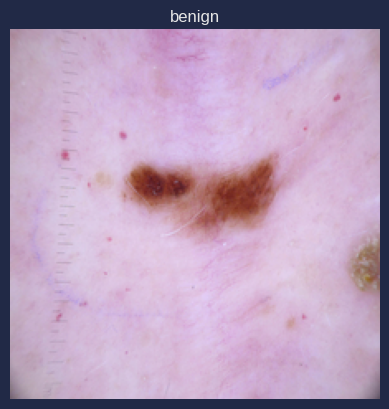

In [28]:
path = '../SCMB/data/test/benign/105.jpg'
get_prediction(path)

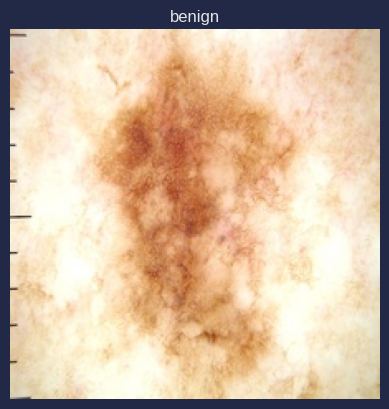

In [29]:
path = '../SCMB/data/test/malignant/200.jpg'
get_prediction(path)

In [30]:
path = '../models/resnet_weights_SCMB.pt'
torch.save(model_SCMB.state_dict(), path)

In [31]:
def plot_f1(history, grid=True):
    fig, ax = plt.subplots(1,1, figsize=(6,5))
    
    ax.plot(history['f1_score_train'], label='train f1_score')
    ax.plot(history['f1_score_valid'], label='valid f1_score ')
    ax.set_title(f'f1_score on epoch {len(history["f1_score_train"])}')
    ax.grid(grid)
    ax.set_ylim((min(history['f1_score_train'] + history['f1_score_valid']) - .1, max(history['f1_score_train'] + history['f1_score_valid']) + .1))
    ax.legend()
    
    
    plt.show()

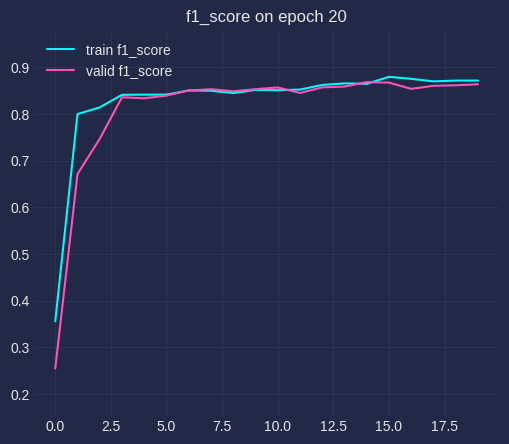

In [32]:
plot_f1(res_SCMB)

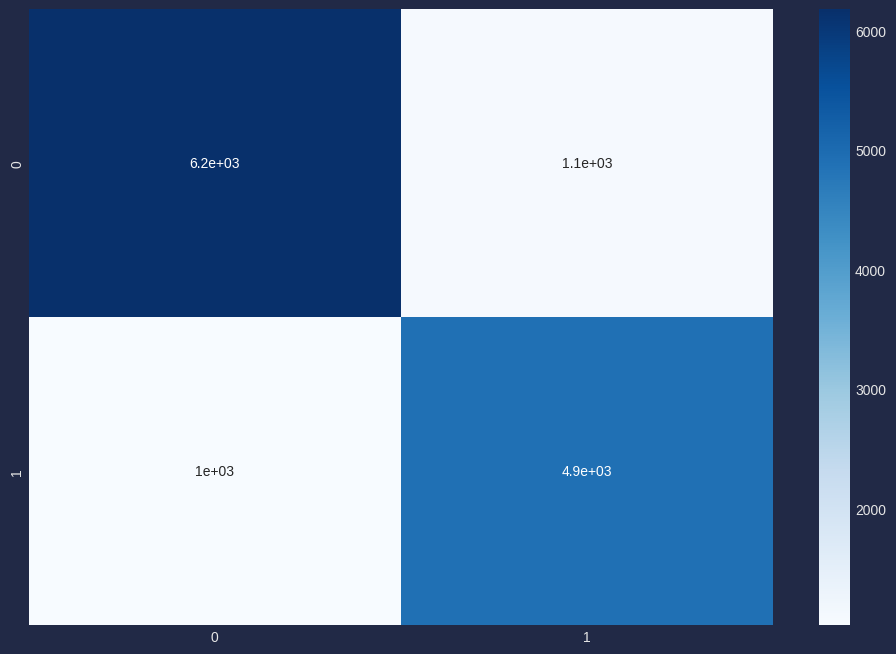

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(confusion_matrix(res_SCMB['y_pred'], res_SCMB['labels']), annot=True, cmap='Blues');